<h3 align="center">Instituto Tecnológico de Aeronáutica - ITA</h3>

<h3 align="center">Introdução a Ciência de Dados - CMC-13</h3>

<h3 align="center">Equipe: Fernando Zanchitta, Guilherme Kowalczuk, Rafael Frisch e Yuri Gama</h3>

---

# Laboratório de Exame

O objetivo desse laboratório é exercitar e fixar os conhecimentos aprendidos em CMC-13 por meio da prática de técnicas de Ciência de Dados em uma base de dados fornecida. Para isso, foi utilizado o *dataset* de dados sobre imóveis no Reino Unido e seus respectivos preços. O objetivo desse laboratório é prever o preço de um imóvel a partir de suas características utilizando técnicas de regressão baseadas em Redes Neurais do tipo MLP e em Árvores de Decisão. Por fim, é realizado um estudo comparativo entre os dois modelos, com o intuito de verificar qual deles apresenta melhor desempenho para o problema em questão. Para isso, são avaliados medidas de desempenho diversas. Por fim, aplicamos o modelo em um conjunto de dados de teste para verificar o desempenho do modelo em dados não vistos.

## 0. Aquisição dos dados:

Nessa etapa vamos fazer o download do conjunto de dados a ser utilizado. Essa etapa é opcional caso os dados já estejam no diretório do projeto. Caso não haja o pacote `gdown` em Python e o arquivo já esteja no diretório do projeto, basta comentar essa linha de código.

In [56]:
!gdown 16tT3wHeWoUvlp9pEi3E4Q9L_msZr5v-t

Downloading...
From: https://drive.google.com/uc?id=16tT3wHeWoUvlp9pEi3E4Q9L_msZr5v-t
To: /Users/kowalks/dev/cmc13-exame/UK_real_estate.csv
100%|████████████████████████████████████████| 190k/190k [00:00<00:00, 2.95MB/s]


## 1. Preparação dos dados

Aqui vamos fazer o carregamento e o pré-processamento dos dados a serem utilizados. O intuito dessa preparação é deixar os dados prontos para a posterior aplicação nos modelos estudados. Para isso, foi utilizado o pacote `pandas` para a manipulação dos dados. Os tipos das variáveis foram especificados conforme descrito no arquivo `real_estate.txt`. Assim, variáveis numéricas foram encodificadas com tipo inteiro e variáveis categóricas foram encodificadas com tipo *string*.

In [57]:
import pandas as pd
import numpy as np

columns = {
    'Price': np.int64,
    'Location': str,
    'Postal Code': str,
    'Area': np.int64,
    'Bedrooms': np.int64,
    'Bathrooms': np.int64,
    'Receptions': np.int64,
    'City-County': str,
    'House-Type': str,
}
data = pd.read_csv('UK_real_estate.csv', index_col=False, usecols=columns.keys(), dtype=columns)
data.head()

,Price,Location,Postal Code,Area,Bedrooms,Bathrooms,Receptions,City-County,House-Type
0,1675000,Wimbledon,SW19 8NY,2716,5,5,5,London,House
1,650000,Clerkenwell,EC1V 3PA,814,2,2,2,London,Flat / Apartment
2,735000,Putney,SW15 1QL,761,2,2,2,London,Flat / Apartment
3,1765000,Putney,SW15 1LP,1986,4,4,4,London,House
4,675000,Putney,SW15 1PL,700,2,2,2,London,Flat / Apartment


Já é possível ver se há valores faltantes no *dataset* para um futuro tratamento. Nesse caso, observou-se que há 2958 registros (linhas) na base de dados, e nenhum campo tem valores faltantes para quase todas as colunas, exceto `Location`. O tratamento desses dados será feito posteriormente, após a divisão em treino e teste.

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2958 entries, 0 to 2957
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Price        2958 non-null   int64 
 1   Location     2096 non-null   object
 2   Postal Code  2958 non-null   object
 3   Area         2958 non-null   int64 
 4   Bedrooms     2958 non-null   int64 
 5   Bathrooms    2958 non-null   int64 
 6   Receptions   2958 non-null   int64 
 7   City-County  2958 non-null   object
 8   House-Type   2958 non-null   object
dtypes: int64(5), object(4)
memory usage: 208.1+ KB


### 1.1. Pré-Processamento

#### 1.1.1 Processamento de variáveis indentificadoras

Aqui, vamos remover as variáveis que não serão utilizadas no modelo porque não trazem informação útil para a predição. As variáveis identificadoras são aquelas que são diferentes para todo conjunto de dados. Assim basta verificar se a quantidade de valores únicos é igual a de eventos. No caso descrito, não há nenhuma variável nesssa categoria.

In [59]:
index_columns = data.columns[data.nunique()==len(data)]
print("Atributos identificadores: ", index_columns)

print("Removendo atributos identificadores...")
data = data.drop(columns=index_columns)

Atributos identificadores:  Index([], dtype='object')
Removendo atributos identificadores...


#### 1.1.2. Processamento de variáveis irrelevantes

São variáveis que possuem o mesmo valor entre si independente do evento. Essas variáveis não ajudam na predição, porque seu valor independe do dado.

In [60]:
irrelevant_columns = data.columns[data.nunique()==1]
print("Atributos irrelevantes: ", irrelevant_columns)

print("Removendo atributos irrelevantes...")
data = data.drop(columns = irrelevant_columns)

Atributos irrelevantes:  Index([], dtype='object')
Removendo atributos irrelevantes...


#### 1.1.3. Processamento das variáveis categóricas

As variáveis categóricas são aquelas encodificadas como `string` e que categorizam os dados não numéricos em algumas classes. Para isso, vamos analisar novamente os tipos das variáveis e o número de valores únicos.

In [61]:
pd.DataFrame({
    'Contagem': data.count(),
    'Valores únicos': data.nunique(),
    'Tipo': data.dtypes,
})

,Contagem,Valores únicos,Tipo
Price,2958,470,int64
Location,2096,573,object
Postal Code,2958,2487,object
Area,2958,1808,int64
Bedrooms,2958,11,int64
Bathrooms,2958,11,int64
Receptions,2958,11,int64
City-County,2958,51,object
House-Type,2958,8,object


Das variáveis descritas, temos
- Colunas categórica: `Location`, `Postal Code`, `City-County` e `House-Type`
- Colunas numéricas contínuas: `Area`
- Colunas numéticas discretas: `Bedrooms`, `Bathrooms`, `Receptions`

In [62]:
category_columns = ['Location','Postal Code','City-County','House-Type']
continuous_columns = ['Area']
discrete_columns = ['Bedrooms','Bathrooms','Receptions']

data[category_columns] = data[category_columns].astype('category')

#### 1.1.4 Distribuição do preço

Histograma de distribuição da variável target *preço*. Perceba que o preço é uma variável contínua, e que a maioria dos preços está entre 0 e 1 milhão de libras. No entanto, é possível ver que há muita discrepância entre os preços, com alguns imóveis custando mais de 10 milhões de libras.

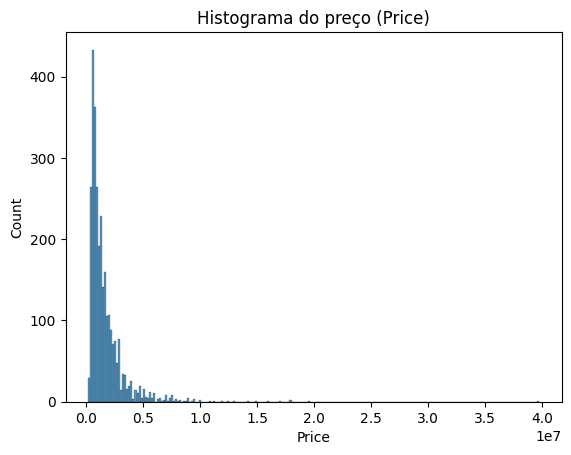

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data, x='Price').set_title('Histograma do preço (Price)')
plt.show()


Como o intervalo de preços é muito grande (em ordem de grandezas), faz sentido adotar o preço em escala logaritmica. Assim, valiamos o logaritmo do preço, e não o preço em si. Isso é feito para evitar que o modelo seja enviesado para os imóveis mais caros, que são poucos, e não generalize bem para os imóveis mais baratos, que são a maioria.

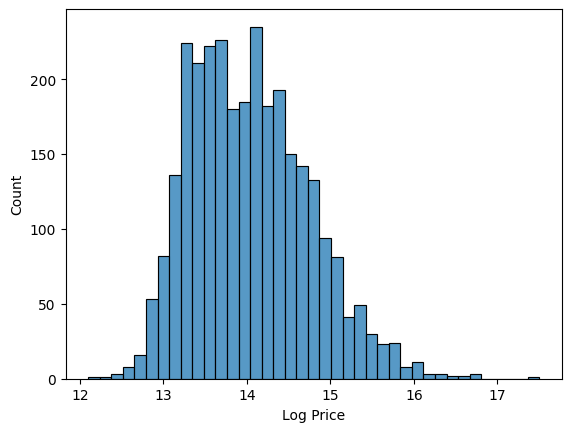

In [64]:
data['Log Price'] = np.log(data['Price'])
sns.histplot(data, x='Log Price')
plt.show()

### 1.2 Separação em Treino/Teste

Aqui, há a separação dos dados em treino e teste. Essa separação é feita antes da análise exploratória para que não haja vazamento de dados na engenharia de atributos. Assim, os dados de teste não são utilizados para a análise exploratória, e são utilizados apenas para a avaliação do modelo. Dessa maneira, é emulado um cenário real, em que o modelo é treinado com dados passados e testado com dados futuros.

Foi definido que os dados de teste representam 20% do total de dados disponíveis. Foi utilizado o atributo `random_state`, do `scikit-learn`, para que a separação seja sempre a mesma (em rodadas futuras do script), e não haja variação nos resultados.

In [65]:
from sklearn.model_selection import train_test_split

target_variable = ['Price', 'Log Price']

X = data.drop(columns=target_variable)
y = data[target_variable]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state=23
)
train = pd.concat([X_train, y_train], axis='columns')
train.head()

,Location,Postal Code,Area,Bedrooms,Bathrooms,Receptions,City-County,House-Type,Price,Log Price
2040,Northwood,HA6 2TA,2055,4,4,4,Middlesex,House,1295000,14.074021
1667,NaN,SW11 4EN,2235,5,5,5,London,House,2500000,14.731801
2050,Tadworth,KT20 6HZ,5380,6,6,6,Surrey,House,2850000,14.862830
744,Islington,N1 2HW,2216,4,4,4,London,House,3500000,15.068274
2683,NaN,SW11 4PT,2090,4,4,4,London,House,1950000,14.483340


Agora, há somente 2366 linhas no conjunto de dados de treino.

In [71]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2366 entries, 2040 to 595
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Location     1685 non-null   category
 1   Postal Code  2366 non-null   category
 2   Area         2366 non-null   int64   
 3   Bedrooms     2366 non-null   int64   
 4   Bathrooms    2366 non-null   int64   
 5   Receptions   2366 non-null   int64   
 6   City-County  2366 non-null   category
 7   House-Type   2366 non-null   category
 8   Price        2366 non-null   int64   
 9   Log Price    2366 non-null   float64 
dtypes: category(4), float64(1), int64(5)
memory usage: 250.7 KB


### 1.3 Valores Faltantes
Antes de realizar imputação de variáveis, devemos observar qual a proporção de valores faltantes nos dados apresentados. Isso é necessário pois etapas de inserção de dados faltantes funcionam melhor quando a porcentagem de valores faltantes é menor que 10% do conjunto de dados. Assim, analisamos a proporção de dados faltantes em cada coluna.

In [73]:
X_train.isna().sum() / len(X_train)

Location       0.287828
Postal Code    0.000000
Area           0.000000
Bedrooms       0.000000
Bathrooms      0.000000
Receptions     0.000000
City-County    0.000000
House-Type     0.000000
dtype: float64

Podemos decidir usar a variável Location com $28.8\%$ de dados faltantes, e realizar um método de imputação.

In [68]:
train['']

2040                Northwood
1667                      NaN
2050                 Tadworth
744                 Islington
2683                      NaN
                ...          
1512                   Ealing
1993                      NaN
1064    55 Primrose Hill Road
742                Marylebone
595                  Surbiton
Name: Location, Length: 2366, dtype: category
Categories (573, object): [' 35 Salusbury Road', ' 352 Queenstown Road', ' 372 Queenstown Road', ' 50 Shad Thames', ..., 'Wimbledon', 'Winchester Road', 'Woodford Green', 'Woodstock Road']

### 1.4 Análise exploratória dos dados

Aqui, vamos fazer uma pequena análise exploratória dos dados, com o intuito de conhecer melhor a base de dados e ajudar nos processos de modelagem que serão desenvolvidos em sequência. A ideia é tentar inferir, visualmente, intuição sobre os dados e a relação entre as colunas e a variável alvo `Price`.

In [69]:
train = pd.concat([X_train,y_train], axis='columns')

In [70]:
sns.catplot(data = train, x = 'Location', y = 'log_Price', kind='box')
#TODO: ajeitar isso

ValueError: Could not interpret input 'log_Price'

In [ ]:
train.dtypes

Location       category
Postal Code    category
Area              int64
Bedrooms          int64
Bathrooms         int64
Receptions        int64
City-County    category
House-Type     category
Price             int64
log_Price       float64
dtype: object

In [ ]:
# Compute the correlation matrix
correlation_matrix = train.corr()

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

ValueError: could not convert string to float: 'Northwood'

TODO: Escrever alguma coisa. Verificar se queremos deletar algumas redundâncias.

## 2. Modelo baseado em Árvores de Decisão ou Em Florestas Aleatórias (Random Forests)

Descrever procedimentos realizados para concluir esta tarefa.

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the random grid
random_grid = {'RF__n_estimators': n_estimators,
               'RF__max_features': max_features,
              #  'RF__max_depth': max_depth,
               'RF__min_samples_split': min_samples_split,
               'RF__min_samples_leaf': min_samples_leaf,
              #  'RF__bootstrap': bootstrap
               }
print(random_grid)

{'RF__n_estimators': [200, 650, 1100, 1550, 2000], 'RF__max_features': ['auto', 'sqrt'], 'RF__min_samples_split': [2, 5, 10], 'RF__min_samples_leaf': [1, 2, 4]}


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# for feature engineering
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
RF_pipeline = Pipeline([('imputer_cat',
     mdi.CategoricalImputer(variables='Location')),

    ('encoder_rare_label',
     ce.RareLabelEncoder(tol=0.01,
                                    n_categories=2,
                                    variables=category_columns)),
    ('categorical_encoder',
     ce.OneHotEncoder(variables=category_columns)),

    # Random Forest Regressor
    ('RF', RandomForestRegressor(random_state=23))
])

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer
score_method = {"MAPE":'neg_mean_absolute_percentage_error', "RMSE":"neg_root_mean_squared_error","R2":'r2'}
scv = StratifiedKFold()
RF_grid_search = GridSearchCV(RF_pipeline,
                              param_grid = random_grid,
                              cv
                              = scv,
                              n_jobs = -1,
                              scoring = score_method,
                              refit = "MAPE")

In [ ]:
RF_grid_search.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('imputer_cat',
                                        CategoricalImputer(variables='Location')),
                                       ('encoder_rare_label',
                                        RareLabelEncoder(n_categories=2,
                                                         tol=0.01,
                                                         variables=['Location',
                                                                    'Postal '
                                                                    'Code',
                                                                    'City-County',
                                                                    'House-Type'])),
                                       ('categorical_encoder',
                                        OneHotEncoder(variables=['Location',
                                                                 'P...
                                                                 'City-County',
                                                                 'House-Type'])),
                                       ('RF',
                                        RandomForestRegressor(random_state=23))]),
             n_jobs=-1,
             param_grid={'RF__max_features': ['auto', 'sqrt'],
                         'RF__min_samples_leaf': [1, 2, 4],
                         'RF__min_samples_split': [2, 5, 10],
                         'RF__n_estimators': [200, 650, 1100, 1550, 2000]},
             refit='MAPE',
             scoring={'MAPE': 'neg_mean_absolute_percentage_error', 'R2': 'r2',
                      'RMSE': 'neg_root_mean_squared_error'})

In [ ]:
RF_grid_search.best_params_


{'RF__max_features': 'auto',
 'RF__min_samples_leaf': 1,
 'RF__min_samples_split': 10,
 'RF__n_estimators': 1100}

In [ ]:
# Get the best estimator
best_estimator = RF_grid_search.best_estimator_

# Perform cross-validation and get the results
cv_results = RF_grid_search.cv_results_

# Extract the scores for each fold
# mean_scores = [cv_results['mean_test_{}'.format(metric)] for metric in score_method.keys()]
mean_scores = {"RMSE":
               (-1)* cv_results['mean_test_RMSE'].mean(),
               "MAPE":
               (-1)* cv_results['mean_test_MAPE'].mean(),
               "R2":
               (-1)* cv_results['mean_test_R2'].mean(),
               }
std_scores = {"RMSE":
               cv_results['std_test_RMSE'].mean(),
               "MAPE":
               cv_results['std_test_MAPE'].mean(),
               "R2":
               cv_results['std_test_R2'].mean(),
               }
params = cv_results['params']


<Axes: >

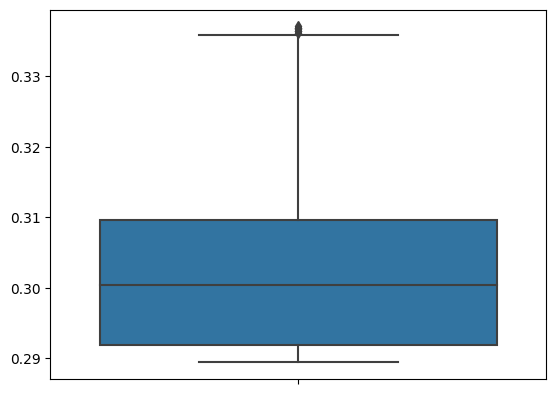

In [ ]:
sns.boxplot(y=(-1)*cv_results['mean_test_MAPE'])

In [ ]:
best_random = RF_grid_search.best_estimator_
predictions_rf = best_random.predict(X_test)

# metrics of prediction:


In [ ]:
def regression_metrics(model_predicted, y_test,model_name):
    rmse_ = np.sqrt(metrics.mean_squared_error(model_predicted,y_test))
    r2 = metrics.r2_score(y_test, model_predicted)
    mape = metrics.mean_absolute_percentage_error(y_test, model_predicted)
    print(model_name," RMSE: ", rmse_)
    print(model_name,"R2: " + str(r2))
    print(model_name,"MAPE: " + str(mape))
    return rmse_, r2, mape

def actual_vs_pred_plot(y_train,y_pred,model_name):

    fig = plt.figure(figsize=(12,12))
    fig, ax = plt.subplots()

    ax.scatter(y_train, y_pred,color = "teal",edgecolor = 'lightblue')
    ax.plot([y_train.min(),y_train.max()], [y_train.min(), y_train.max()], 'k--',lw=0.2)
    ax.set_xlabel('Atual')
    ax.set_ylabel('Predito')
    plt.suptitle(model_name + ' - Actual vs Predicted Values',size=14)
    plt.show()
def model_dist_plot(y_test,y_pred,model_name):
    plt.figure(figsize=(10,5))
    sns.histplot(y_test, kde=False)
    sns.histplot(y_pred, kde=False)
    plt.title(model_name + ' - Distribution Plot')
    plt.legend(labels=['Actual Values of Price', 'Predicted Values of Price'])
    plt.xlim(0,)
def model_residual_plot(test_Y,model_predicted,model_name):

    residuals = test_Y - model_predicted
    plt.scatter(model_predicted, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(model_name + ' - Residual Plot')
    plt.show()

Modelo de Random Forest
Randomforest  RMSE:  1636890.3894854493
Randomforest R2: 0.42295578068635054
Randomforest MAPE: 0.3096074956161527


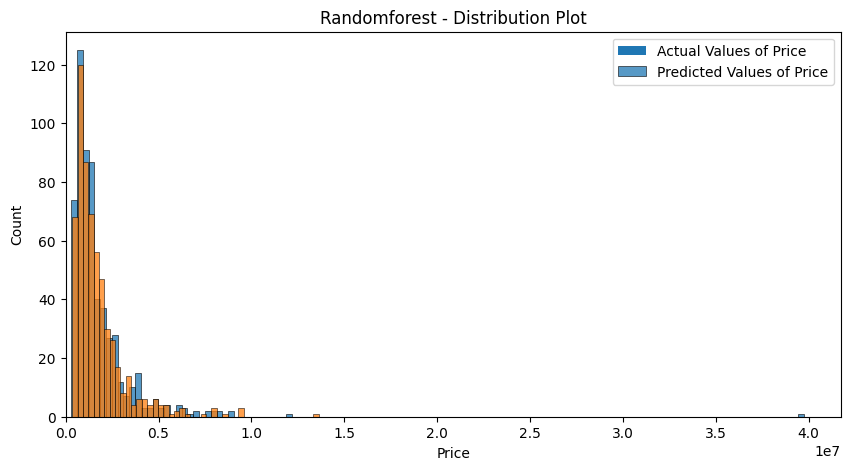

<Figure size 1200x1200 with 0 Axes>

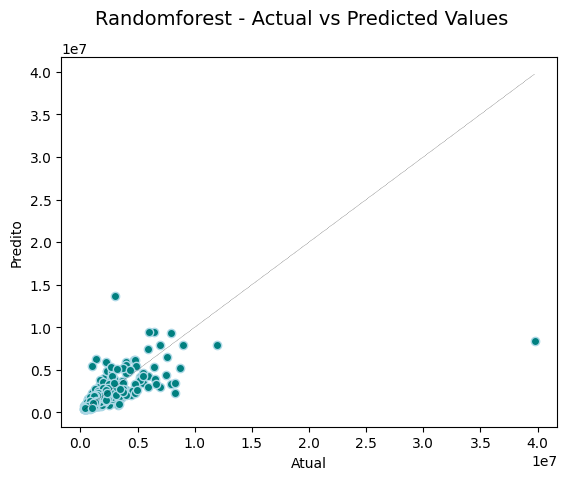

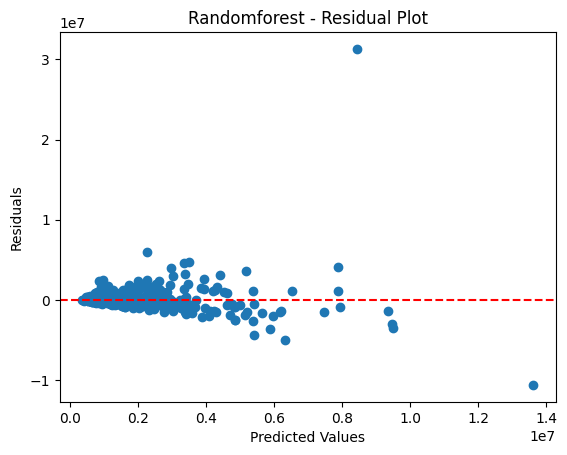

In [ ]:
print('Modelo de Random Forest')
rmse, r2, mape = regression_metrics(predictions_rf, y_test,'Randomforest')

model_dist_plot(y_test, predictions_rf, 'Randomforest')

actual_vs_pred_plot(y_test, predictions_rf,'Randomforest')

# Create residual plot
model_residual_plot(y_test, predictions_rf, 'Randomforest')

## 3. Modelo baseado em Redes Neurais do tipo MLP (MultiLayer Perceptron)

Descrever procedimentos realizados para concluir esta tarefa.

In [ ]:
data

,Price,Location,Postal Code,Area,Bedrooms,Bathrooms,Receptions,City-County,House-Type,log_Price
0,1675000,Wimbledon,SW19 8NY,2716,5,5,5,London,House,14.331324
1,650000,Clerkenwell,EC1V 3PA,814,2,2,2,London,Flat / Apartment,13.384728
2,735000,Putney,SW15 1QL,761,2,2,2,London,Flat / Apartment,13.507626
3,1765000,Putney,SW15 1LP,1986,4,4,4,London,House,14.383661
4,675000,Putney,SW15 1PL,700,2,2,2,London,Flat / Apartment,13.422468
...,...,...,...,...,...,...,...,...,...,...
2953,2250000,NaN,W4 3UR,2469,4,4,4,London,House,14.626441
2954,3950000,St. John's Wood,NW8 9UG,2803,5,5,5,London,House,15.189226
2955,1750000,NaN,SE17 2JX,2396,5,5,5,London,House,14.375126
2956,1195000,Marylebone,W1U 5BR,678,1,1,1,London,Flat / Apartment,13.993657


In [ ]:
from tensorflow.keras import layers, activations, regularizers, optimizers, losses, metrics
from tensorflow.keras.models import Sequential

lambda_l2 = 0
def create_model(input_shape):
    model = Sequential()
    model.add(layers.Dense(19, activation=activations.relu, input_shape=(input_shape, )))
    model.add(layers.Dense(19, activation=activations.relu))
    model.add(layers.Dense(19, activation=activations.relu))
    model.add(layers.Dense(19, activation=activations.relu))
    model.add(layers.Dense(1, activation=activations.linear))
    model.summary()
    model.compile(optimizer="adam", loss=losses.mse, metrics=["accuracy"])
    return model

In [ ]:
X = data.drop(columns = ['Price','log_Price'])
y = data['Price']
from sklearn.preprocessing import LabelEncoder
cat_columns = category_columns+discrete_columns
label_encoders = {}
for column in cat_columns:
  le = LabelEncoder()
  X[column] = le.fit_transform(X[column].astype(str))
  label_encoders[column] = le

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state=23)

In [ ]:
model = create_model(X_train.shape[1])
history = model.fit(X_train, np.log(y_train), epochs = 2000, validation_split = 0.2)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_135 (Dense)           (None, 19)                171       
                                                                 
 dense_136 (Dense)           (None, 19)                380       
                                                                 
 dense_137 (Dense)           (None, 19)                380       
                                                                 
 dense_138 (Dense)           (None, 19)                380       
                                                                 
 dense_139 (Dense)           (None, 1)                 20        
                                                                 
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
52/52 [==============================]

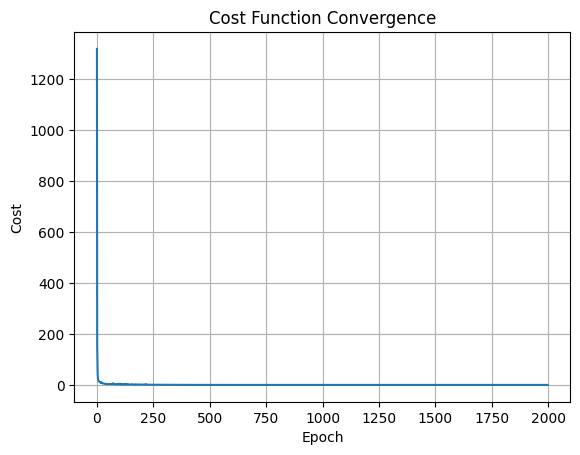

In [ ]:
# Plotting cost function convergence
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Cost Function Convergence')
plt.grid()
plt.show()

28/28 [==============================] - 0s 1ms/step


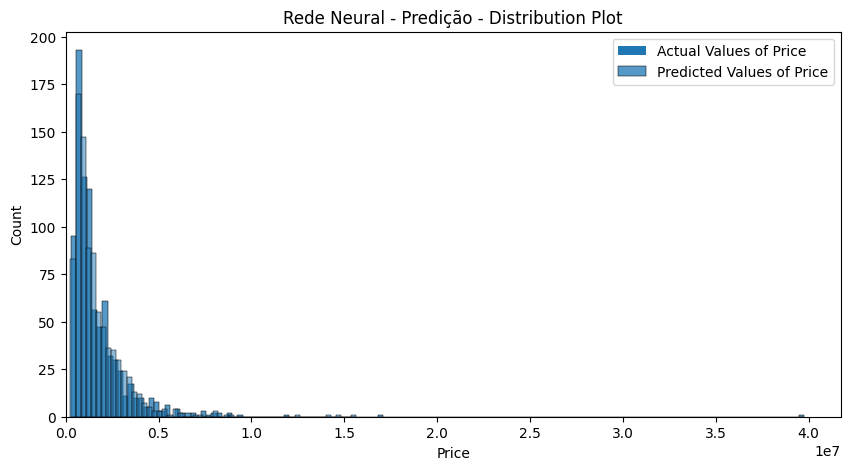

<Figure size 1200x1200 with 0 Axes>

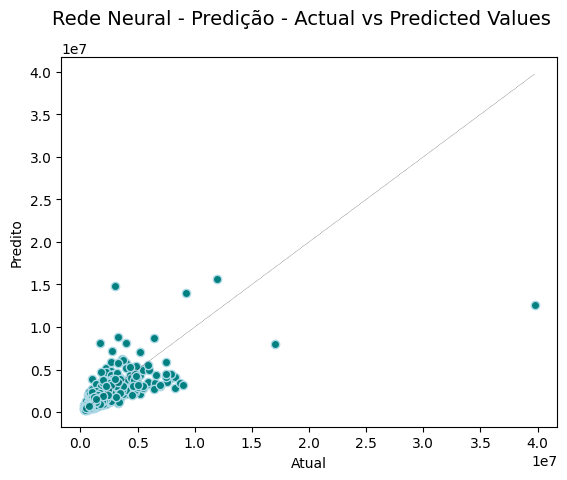

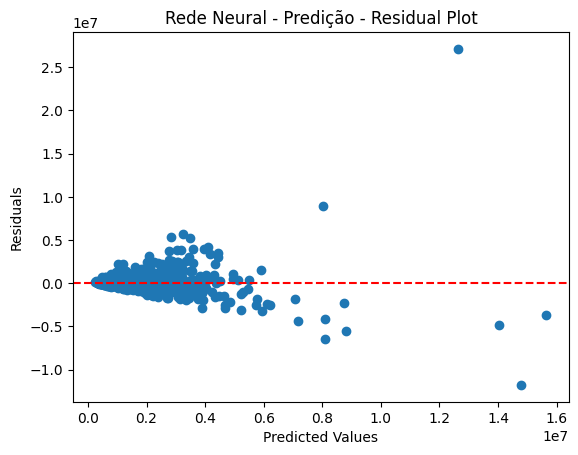

In [ ]:
predictions = np.exp(model.predict(X_test))

model_dist_plot(y_test, predictions, 'Rede Neural - Predição')
actual_vs_pred_plot(y_test, predictions, "Rede Neural - Predição")


# Create residual plot
model_residual_plot(y_test, predictions[:,0], 'Rede Neural - Predição')


65/65 [==============================] - 0s 1ms/step


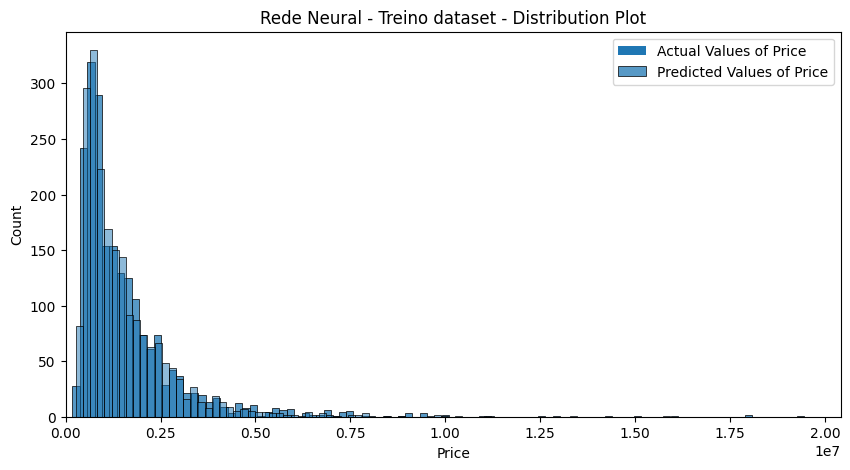

<Figure size 1200x1200 with 0 Axes>

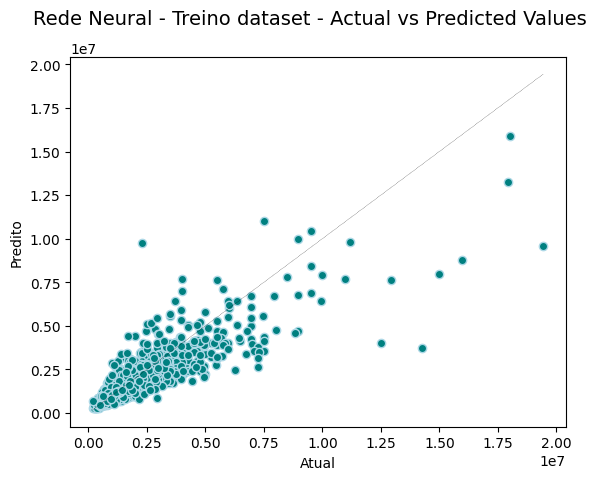

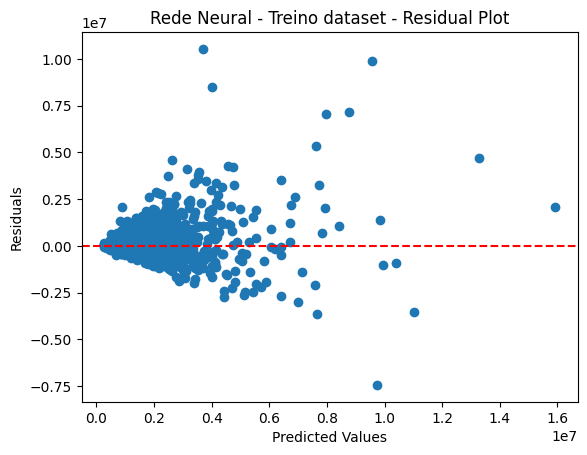

In [ ]:
predictions = np.exp(model.predict(X_train))

model_dist_plot(y_train, predictions, 'Rede Neural - Treino dataset')
actual_vs_pred_plot(y_train, predictions, "Rede Neural - Treino dataset")


# Create residual plot
model_residual_plot(y_train, predictions[:,0], 'Rede Neural - Treino dataset')

In [ ]:
!gdown 16tT3wHeWoUvlp9pEi3E4Q9L_msZr5v-t
columns = {
    "Price": np.uint32,
    "Location": str,
    "Postal Code": str,
    "Area": np.uint16,
    "Bedrooms": np.uint8,
    "Bathrooms": np.uint8,
    "Receptions": np.uint8,
    "City-County": str,
    "House-Type": str,
    }
data = pd.read_csv('UK_real_estate.csv',index_col = False, usecols = columns.keys(), dtype= columns)

Downloading...
From: https://drive.google.com/uc?id=16tT3wHeWoUvlp9pEi3E4Q9L_msZr5v-t
To: /content/UK_real_estate.csv
100% 190k/190k [00:00<00:00, 11.4MB/s]


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
X = data.drop(columns = ['Price'])
y = np.log(data['Price'])
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state=23)

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(100, 50, 30, 1), max_iter=1000)

In [ ]:
mlp.fit(X_train, y_train)

AttributeError: ignored

## 4. Análise Comparativa do desempenho dos modelos

Apresente os dados e discussões sobre os resultados, inclusive dados sobre o desempenho no dataset de treino e testes.

## 5. Aplicação da predição do Modelo Desenvolvido

Trecho de código para uso do modelo desenvolvido aplicado a um arquivo de dado do mesmo formato do arquivo de dados fornecido (UK_real_estate.csv). O nome do arquivo de dados de testes será `UK_real_estate_test.csv`.

## 6. Conclusões

Comentários e sugestões sobre o trabalho (complexidade/facilidade, sugestões, etc.).